In [1]:
import numpy as np

In [2]:
#LED = np.array([600.83276, 583.095, 1025.91, 160, 260, 273.13, 230])

In [3]:
#RED = np.array([657.34314, 565.685, 460.977, 684.47, 282.312, 743.303, 876.64])

In [4]:
#Fold_lick = np.array([0.037351, 0.232523, 1.580247, 1.156522, 0.36383, 0.315789, 0.210604])

In [186]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import re
import seaborn as sns

In [144]:
## Mark experimental and control rats
experimental = ['TJM18',	'TJM19',	'TJM22',	'TJM27',	'TJM29',	'TJM34',	'TJM35',	'TJM37']
control = ['TJM12',	'TJM13',	'TJM24',	'TJM25',	'TJM31']

all_names = [*experimental,*control]
# Convert to dictionary
expt_dict = {name:'exp' for name in experimental}
con_dict = {name: 'con' for name in control}
full_dict = {**expt_dict,**con_dict}
print(all_names)
print(full_dict)

['TJM18', 'TJM19', 'TJM22', 'TJM27', 'TJM29', 'TJM34', 'TJM35', 'TJM37', 'TJM12', 'TJM13', 'TJM24', 'TJM25', 'TJM31']
{'TJM18': 'exp', 'TJM19': 'exp', 'TJM22': 'exp', 'TJM27': 'exp', 'TJM29': 'exp', 'TJM34': 'exp', 'TJM35': 'exp', 'TJM37': 'exp', 'TJM12': 'con', 'TJM13': 'con', 'TJM24': 'con', 'TJM25': 'con', 'TJM31': 'con'}


In [250]:
## Load data
data_time_series = pd.read_csv('https://raw.githubusercontent.com/abuzarmahmood/data_for_google_colab/main/poke_series.csv')
# Each bin in data_time_series is 30secs, 60 bins = 30mins
data_time_series = data_time_series

In [237]:
# Pull out 'successful_pokes'
data_time_series = data_time_series.loc[data_time_series['data_type'] == 'successful_pokes']
# Pull out CTA data
data_time_series = data_time_series.loc[data_time_series['expt_dat'].str.contains('CTA')]
# Convert expt_dat names
data_time_series['expt_dat'] = [x[1] for x in data_time_series['expt_dat'].str.split('_')]
# Remove Test 2
data_time_series = data_time_series.loc[~data_time_series['expt_dat'].str.contains('2')]
# Lowercase
data_time_series['expt_dat'] = data_time_series['expt_dat'].str.lower()
# Remove numbers
data_time_series['expt_dat'] = [re.findall('[A-Za-z]+',x)[0] for x in data_time_series['expt_dat']]
# Take only relevant animals
data_time_series = data_time_series.loc[data_time_series['animal_name'].isin(all_names)]
# Add experimental groups
data_time_series['group'] = [full_dict[x] for x in data_time_series['animal_name']]
# Move column to front
cols = data_time_series.columns.tolist()
fin_cols = cols[:4]+[cols[-1]]+cols[4:-1]
data_time_series = data_time_series.loc[:,fin_cols]

In [238]:
# # Calculate rolling window average on nosepoke counts
# poke_array = data_time_series.iloc[:,5:].to_numpy()
# # Stop at 60 bins
# poke_array = poke_array[:,:60]
# plt.imshow(poke_array,aspect='auto')
# plt.figure()
# plt.plot(poke_array.T);

In [239]:
# Convert data to longform data
data_time_series = pd.melt(data_time_series,id_vars=data_time_series.columns[:5],var_name='bin', value_name='pokes')
# Convert to numreic
data_time_series['bin'] = pd.to_numeric(data_time_series['bin'])
# Cut off after 60 bins
data_time_series = data_time_series.loc[data_time_series['bin'] < 60]

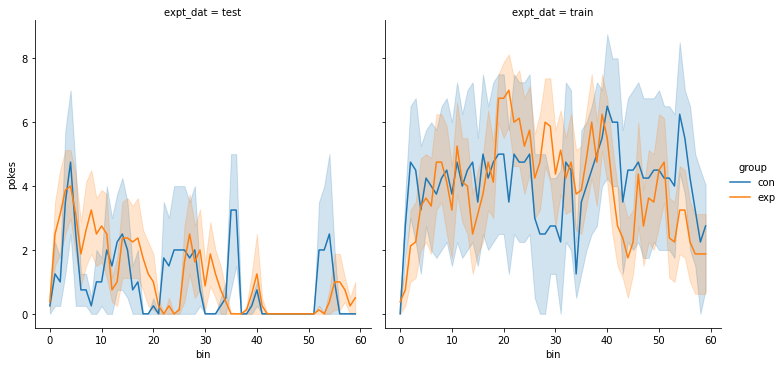

In [240]:
# Plot timeseries by group
sns.relplot(data=data_time_series, x="bin", y="pokes", hue = 'group',kind = 'line', col = 'expt_dat',ci=68)

In [293]:
data_array = pd.read_csv('https://raw.githubusercontent.com/abuzarmahmood/data_for_google_colab/main/raw_lick_counts.csv')
## Perform cleanup
##Did you drop TJM37 and all control animals?
data_array.drop(labels = 'Unnamed: 14', axis=1,inplace=True)
data_array = data_array.transpose()

In [294]:
data_array.columns = data_array.iloc[0]
data_array['animal_number'] = data_array.index
data_array.drop(labels = 'Unnamed: 0', axis=0,inplace=True)
data_array.reset_index(inplace=True,drop=True)

In [295]:
# Add condition for each animal
data_array['condition'] = [full_dict[x] for x in data_array['animal_number']]

In [296]:
# Calculate total and average distances for each hemisphere
data_array['dist_L'] = np.vectorize(np.sqrt)(data_array['MLL']**2 + data_array['DVL']**2)
data_array['dist_R'] = np.vectorize(np.sqrt)(data_array['MLR']**2 + data_array['DVR']**2)
data_array['avg_total_dist'] = np.mean(data_array[['dist_L','dist_R']],axis=1)
data_array['avg_ML'] = np.mean(data_array[['MLL','MLR']],axis=1)
data_array['avg_DV'] = np.mean(data_array[['DVL','DVR']],axis=1)

In [297]:
# Calculate fold change relative to training day
data_array['fold_change'] = data_array['Test']/data_array['Train']
data_array['fold_change_1'] = data_array['H20 last day']/data_array['Train']

In [298]:
data_array

Unnamed: 0,H20 last day,Train,Test,MLL,MLR,DVL,DVR,GCAP,animal_number,condition,dist_L,dist_R,avg_total_dist,avg_ML,avg_DV,fold_change,fold_change_1
0,134,589,22,190,360,570,550,0.9,TJM18,exp,600.832755,657.343137,629.087946,275.0,560.0,0.0373514,0.227504
1,189,658,153,500,400,300,400,1,TJM19,exp,583.095189,565.685425,574.390307,450.0,350.0,0.232523,0.287234
2,431,162,256,750,350,700,300,0,TJM22,exp,1025.914226,460.977223,743.445725,550.0,500.0,1.58025,2.66049
3,574,230,266,160,620,0,290,1.2,TJM27,exp,160.000000,684.470598,422.235299,390.0,145.0,1.15652,2.49565
4,378,119,6,NaN,NaN,NaN,NaN,2.2,TJM29,exp,NaN,NaN,NaN,NaN,NaN,0.0504202,3.17647
5,444,470,171,0,260,260,110,1.1,TJM34,exp,260.000000,282.311884,271.155942,130.0,185.0,0.36383,0.944681
6,386,304,96,250,250,110,700,1.6,TJM35,exp,273.130006,743.303437,508.216722,250.0,405.0,0.315789,1.26974
7,278,679,143,0,740,230,470,NaN,TJM37,exp,230.000000,876.641318,553.320659,370.0,350.0,0.210604,0.409426
8,21,651,0,NaN,NaN,NaN,NaN,NaN,TJM12,con,NaN,NaN,NaN,NaN,NaN,0,0.0322581
9,441,814,680,NaN,NaN,NaN,NaN,NaN,TJM13,con,NaN,NaN,NaN,NaN,NaN,0.835381,0.541769


In [311]:
# Pull out experimental data
exp_data = data_array.loc[data_array.condition == 'exp'].copy()
# Remove data with nans
exp_data.drop(labels = 'GCAP',axis=1,inplace=True)
exp_data.dropna(inplace=True)
LED = exp_data['dist_L']
RED = exp_data['dist_R']
Fold_lick = exp_data['fold_change']
Fold_lick_1 = exp_data['fold_change_1']

In [312]:
exp_data

Unnamed: 0,H20 last day,Train,Test,MLL,MLR,DVL,DVR,animal_number,condition,dist_L,dist_R,avg_total_dist,avg_ML,avg_DV,fold_change,fold_change_1
0,134,589,22,190,360,570,550,TJM18,exp,600.832755,657.343137,629.087946,275.0,560.0,0.0373514,0.227504
1,189,658,153,500,400,300,400,TJM19,exp,583.095189,565.685425,574.390307,450.0,350.0,0.232523,0.287234
2,431,162,256,750,350,700,300,TJM22,exp,1025.914226,460.977223,743.445725,550.0,500.0,1.58025,2.66049
3,574,230,266,160,620,0,290,TJM27,exp,160.000000,684.470598,422.235299,390.0,145.0,1.15652,2.49565
5,444,470,171,0,260,260,110,TJM34,exp,260.000000,282.311884,271.155942,130.0,185.0,0.36383,0.944681
6,386,304,96,250,250,110,700,TJM35,exp,273.130006,743.303437,508.216722,250.0,405.0,0.315789,1.26974
7,278,679,143,0,740,230,470,TJM37,exp,230.000000,876.641318,553.320659,370.0,350.0,0.210604,0.409426


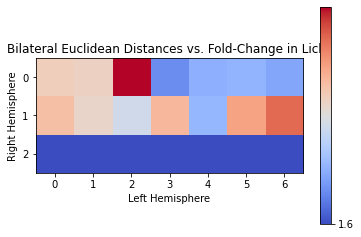

In [313]:
data=np.array([LED,RED,Fold_lick],dtype='float32')
fig,ax=plt.subplots()
cax=ax.imshow(data,cmap=cm.coolwarm)
cbar=fig.colorbar(cax,ticks=[0,1.6])
ax.set_title('Bilateral Euclidean Distances vs. Fold-Change in Licks')
ax.set_xlabel('Left Hemisphere')
ax.set_ylabel('Right Hemisphere')
#plt.scatter(LED, RED, c=Fold_lick, cmap='viridis')
plt.show()

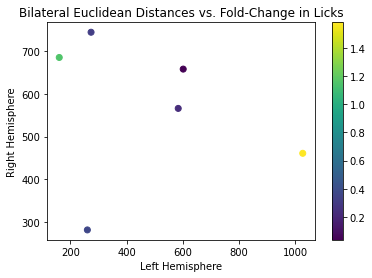

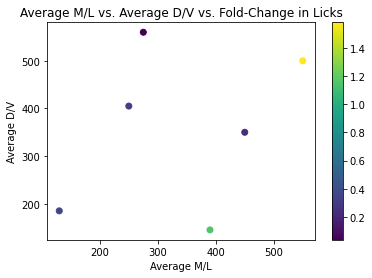

In [ ]:
#Avg_ML = np.array([275, 450, 550, 390, 130, 250, 370])
#Avg_DV = np.array([560, 350, 500, 145, 185, 405, 350])
Avg_ML = exp_data['avg_ML']
Avg_DV = exp_data['avg_DV']

plt.scatter(Avg_ML, Avg_DV, c=Fold_lick, cmap='viridis')
plt.colorbar()
plt.title('Average M/L vs. Average D/V vs. Fold-Change in Licks')
plt.xlabel('Average M/L')
plt.ylabel('Average D/V')
#plt.savefig('C:/Users/tjmur/Downloads/Avg. ML vs. Avg. DV vs. Fold-Change in Licks.png',bbox_inches='tight')
plt.show()


ValueError: ignored

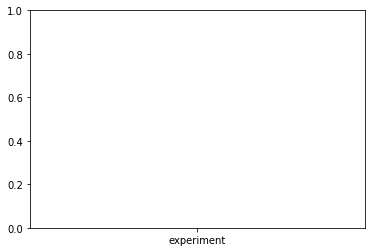

In [ ]:
import matplotlib.pyplot as plt
plt.bar(data_array['condition'],Fold_lick)
plt.title('Fold Change in Pokes Across CTA Learning')
plt.xlabel('Session')
plt.ylabel('Fold-Change in Number of Pokes')
plt.show()

In [ ]:
data_array['avg_total_dist']

0     629.087946
1     574.390307
2     743.445725
3     422.235299
4            NaN
5     271.155942
6     508.216722
7     553.320659
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
Name: avg_total_dist, dtype: float64

In [ ]:
H20_last_day_total_poke_avg = np.mean(data_array['H20 last day'])

In [ ]:
Train_total_poke_avg = np.mean(data_array['Train'])
Test_total_poke_avg = np.mean(data_array['Test'])
Pokes_Across_3_Sessions = np.array([H20_last_day_total_poke_avg, Train_total_poke_avg, Test_total_poke_avg])

H20_last_day_total_poke_std = np.std(data_array['H20 last day'])
Train_total_poke_std = np.std(data_array['Train'])
Test_total_poke_std = np.std(data_array['Test'])
Pokes_Across_3_Sessions_Error = np.array([H20_last_day_total_poke_std,Train_total_poke_std,Test_total_poke_std])

FileNotFoundError: ignored

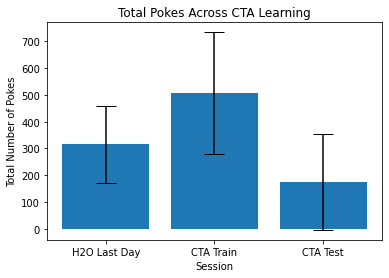

In [ ]:
data = Pokes_Across_3_Sessions
index = ['H2O Last Day', 'CTA Train', 'CTA Test']
Pokes_Across_3_Sessions_Dataframe = pd.DataFrame(data=data, index=index)
Pokes_Across_3_Sessions_Dataframe = plt.bar(x=index, height = data, yerr = Pokes_Across_3_Sessions_Error, capsize = 10)
plt.xlabel('Session')
plt.ylabel('Total Number of Pokes')
plt.title('Total Pokes Across CTA Learning')
plt.savefig('C:/Users/tjmur/Downloads/Total Pokes Across CTA Learning Bar Chart.png',bbox_inches='tight')
#how the f*** do I save this thing?
plt.show(block=True)

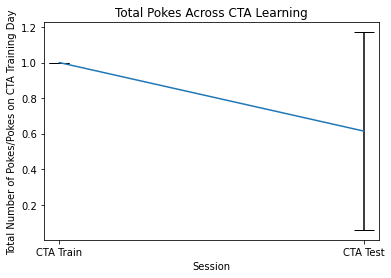

In [ ]:
Fold_lick_avg_test = np.mean([Fold_lick])
Fold_lick_avg_across_sessions = np.array([1, Fold_lick_avg_test])
Fold_lick_std_test = np.std([Fold_lick])
Fold_lick_std_test_across_sessions = np.array([0, Fold_lick_std_test])

x = ['CTA Train', 'CTA Test']
y = Fold_lick_avg_across_sessions
plt.errorbar(x,y, yerr = Fold_lick_std_test_across_sessions, ecolor="black", capsize=10)
plt.xlabel('Session')
plt.ylabel('Total Number of Pokes/Pokes on CTA Training Day')
plt.title('Total Pokes Across CTA Learning')
plt.show()

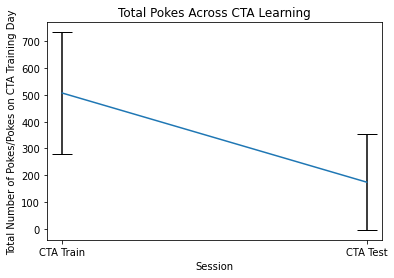

In [ ]:
import numpy as np

Train_total_poke_avg = np.mean(data_array['Train'])
Test_total_poke_avg = np.mean(data_array['Test'])
Pokes_Across_2_Sessions = np.array([Train_total_poke_avg, Test_total_poke_avg])

Train_total_poke_std = np.std(data_array['Train'])
Test_total_poke_std = np.std(data_array['Test'])
Pokes_Across_2_Sessions_Error = np.array([Train_total_poke_std,Test_total_poke_std])

x = ['CTA Train', 'CTA Test']
y = Pokes_Across_2_Sessions
plt.errorbar(x,y, yerr = Pokes_Across_2_Sessions_Error, ecolor="black", capsize=10)
plt.xlabel('Session')
plt.ylabel('Total Number of Pokes/Pokes on CTA Training Day')
plt.title('Total Pokes Across CTA Learning')
plt.show()

FileNotFoundError: ignored

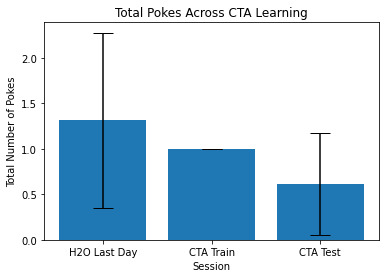

In [ ]:
Fold_lick_avg_test = np.mean([Fold_lick])
Fold_lick_avg_H20_Last_Day = np.mean([Fold_lick_1])
Fold_lick_avg_across_sessions = np.array([Fold_lick_avg_H20_Last_Day, 1, Fold_lick_avg_test])
Fold_lick_std_test = np.std([Fold_lick])
Fold_lick_std_H20_Last_Day = np.std([Fold_lick_1])
Fold_lick_std_test_across_sessions = np.array([Fold_lick_std_H20_Last_Day, 0, Fold_lick_std_test])

data1 = Fold_lick_avg_across_sessions
index = ['H2O Last Day', 'CTA Train', 'CTA Test']
Pokes_Across_3_Sessions_Dataframe1 = pd.DataFrame(data=data1, index=index)
Pokes_Across_3_Sessions_Dataframe1 = plt.bar(x=index, height = data1, yerr = Fold_lick_std_test_across_sessions, capsize = 10)
plt.xlabel('Session')
plt.ylabel('Total Number of Pokes')
plt.title('Total Pokes Across CTA Learning')
plt.savefig('C:/Users/tjmur/Downloads/Total Pokes Across CTA Learning Bar Chart.png',bbox_inches='tight')
#how the f*** do I save this thing?
plt.show(block=True)